<a href="https://colab.research.google.com/github/gabriel-masson/Chika_2025.1/blob/main/XAI_Hiperpar%C3%A2metro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.3 MB/s eta 0:00:00


In [ ]:
# !pip install catboost

In [ ]:
import pandas as pd
import numpy as np

from sklearn.neural_network import MLPClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


from sklearn.model_selection import cross_val_score, LeaveOneOut, KFold

from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
# import catboost

#-

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/_MESTRADO/REPLICK/Base de Dados/V2_BANCO_DOTLAB_347.xlsx')
df.head()

,PID,D0_Diagnóstico CHIKV,D0_Método diagnóstico,D0_Data de início dos sintomas,D0_Data de recrutamento,D0_Fase CHIKF (D0),D0_DPIS ambulat-D0,D0_Dias após inicio de sintomas (DPIS)- recrut,D0_Novo critério (0-3/4-10),D0_Critério anterior (0/1-10),...,D0_intensdor_dedomaod,D0_intensdor_quadrile,D0_intensdor_quadrild,D0_intensdor_joelhoe,D0_intensdor_joelhod,D0_intensdor_tornozeloe,D0_intensdor_tornozelod,D0_intensdor_dedopee,D0_intensdor_dedoped,D0_categoria_ativdoenca
0,REC001,Positivo,TR,2019-08-01,2019-09-09,Subagudo,28,39,1,1,...,4,1,1,3,3,4,4,3,2,3
1,REC002,Positivo,TR,2019-09-01,2019-09-16,Subagudo,10,15,1,1,...,4,4,4,4,4,4,4,1,1,2
2,REC004,Positivo,RT-qPCR (ZDC),2020-07-04,2020-07-08,Agudo,4,4,1,1,...,4,1,1,1,1,1,1,1,1,4
3,REC005,Positivo,TR,2020-05-26,2020-07-08,Subagudo,43,43,1,1,...,3,2,2,2,2,4,4,3,3,4
4,REC006,Positivo,TR,2020-06-19,2020-07-13,Subagudo,24,24,1,1,...,2,1,1,1,1,2,2,3,2,3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Columns: 252 entries, PID to D0_categoria_ativdoenca
dtypes: datetime64[ns](4), float64(12), int64(227), object(9)
memory usage: 683.3+ KB


##Pré-processamento

In [ ]:
def avaliation_model(y_test,y_pred):
  metricas = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True, zero_division=1)).round(4).T.drop('support', axis=1)
  metricas.drop(['macro avg', 'weighted avg'], axis=0, inplace=True)
  auc = roc_auc_score(y_test, y_pred)

  accuracy= (metricas.loc["accuracy", "f1-score"]*100).round(6)
  recall= (metricas.loc["1", "recall"]*100).round(6)
  especificity= (metricas.loc["0", "recall"]*100).round(6)
  precision= (metricas.loc["1", "precision"]*100).round(6)
  f1_score= (metricas.loc["1", "f1-score"]*100).round(6)
  AUC= (auc*100).round(2)
  print(f'Accuracy: {accuracy}')
  print(f'Recall: {recall}')
  print(f'Rspecificity: {especificity}')
  print(f'Precision: {precision}')
  print(f'F1_score: {f1_score}')
  print(f'AUC: {AUC}')


In [ ]:
def cross_val_models_f1(df_train, model):
    X = df_train.drop('D0_Novo critério (0-3/4-10)', axis=1)
    y = df_train['D0_Novo critério (0-3/4-10)'].astype(int)

    kf = KFold(n_splits=10, shuffle=True, random_state=1)
    f1_scorer = make_scorer(f1_score, average='weighted')

    cross_model = cross_validate(model, X, y, cv=kf, scoring=f1_scorer)
    return cross_model['test_score']

In [ ]:
features = [ 'D0_idade', 'D0_genero', 'D0_cor',

            'D0_febre_episodio1',         'D0_cefaleia_episodio1',          'D0_fadiga_episodio1',
             'D0_palidez_episodio1',
             'D0_diarreia_episodio1',
             'D0_parestesia_episodio1',
             'D0_edema_episodio1',       'D0_mialgia_episodio1',
             'D0_rash_episodio1',
             'D0_enpp_fadiga',

             'D0_intensdor_ombroe',
             'D0_intensdor_ombrod',
             'D0_intensdor_punhoe',
             'D0_intensdor_punhod',
             'D0_intensdor_dedomaoe',
             'D0_intensdor_dedomaod',
             'D0_intensdor_joelhoe',
             'D0_intensdor_joelhod',
             'D0_intensdor_tornozeloe',
             'D0_intensdor_tornozelod',
             'D0_intensdor_dedopee',
             'D0_intensdor_dedoped',
             'D0_Novo critério (0-3/4-10)',
]


df_train = df[features]

In [ ]:
df_train.fillna(0, inplace=True)

/tmp/ipython-input-1491490294.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.fillna(0, inplace=True)


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   D0_idade                     347 non-null    int64
 1   D0_genero                    347 non-null    int64
 2   D0_cor                       347 non-null    int64
 3   D0_febre_episodio1           347 non-null    int64
 4   D0_cefaleia_episodio1        347 non-null    int64
 5   D0_fadiga_episodio1          347 non-null    int64
 6   D0_palidez_episodio1         347 non-null    int64
 7   D0_diarreia_episodio1        347 non-null    int64
 8   D0_parestesia_episodio1      347 non-null    int64
 9   D0_edema_episodio1           347 non-null    int64
 10  D0_mialgia_episodio1         347 non-null    int64
 11  D0_rash_episodio1            347 non-null    int64
 12  D0_enpp_fadiga               347 non-null    int64
 13  D0_intensdor_ombroe          347 non-null    int64

In [ ]:
average = 173
X = df_train.drop('D0_Novo critério (0-3/4-10)', axis=1)
y = df_train['D0_Novo critério (0-3/4-10)']

X = df_train.drop('D0_Novo critério (0-3/4-10)', axis=1)

y = df_train['D0_Novo critério (0-3/4-10)'].astype(int)
under_sampler = RandomUnderSampler(sampling_strategy={1: average}, random_state=42)
over_sampler = RandomOverSampler(sampling_strategy={0: average}, random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X, y)
X_resampled, y_resampled = over_sampler.fit_resample(X_resampled, y_resampled)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

##Bayes

In [ ]:
def bayes_search_results(model,name):
  # Obter os melhores parâmetros
  melhor_parametro = model.best_params_

  # Converter o dicionário em DataFrame
  df_melhor_parametro = pd.DataFrame.from_dict(melhor_parametro, orient='index', columns=['Valor'])
  # Adicionar colunas de nome e tipo
  df_melhor_parametro.index.names = ['Nome do Parâmetro']
  df_melhor_parametro['Tipo'] = df_melhor_parametro.index.dtype

  # Exibir o DataFrame
  df_melhor_parametro.to_excel(f'/content/drive/MyDrive/_MESTRADO/REPLICK/Colabs/2025.2/BS_results/XAI_{name}_melhor_parametro.xlsx')

def bayes_search(X_train, y_train, model, search_space):
  model_bayes = BayesSearchCV(
    model,
    search_space,
    n_iter=100,
    cv=3,
    random_state=42,
    verbose=100
)

  # Realize a busca bayesiana
  model_bayes.fit(X_train, y_train)

    # Os melhores hiperparâmetros encontrados
  print("Melhores hiperparâmetros:", model_bayes.best_params_)

  # A melhor pontuação (geralmente uma métrica de desempenho, como precisão)
  print("Melhor pontuação:", model_bayes.best_score_)

  bayes_search_results(model_bayes, model.__class__.__name__)

In [ ]:
models_and_params = {
    # 'AdaBoost': {
    #     'model': AdaBoostClassifier(random_state=42),
    #     'params': {
    #         'n_estimators': Integer(10, 1000),
    #         'learning_rate': Real(0.01, 2.0),
    #         'algorithm': Categorical(['SAMME']),
    #     },
    # },
    # 'GradientBoosting': {
    #     'model': GradientBoostingClassifier(),
    #     'params': {
    #         'n_estimators': Integer(10, 1000),
    #         'max_depth': Integer(2, 1000),
    #         'min_samples_split': Real(0.01, 0.99),
    #         'min_samples_leaf': Real(0.01, 0.5),
    #         'criterion': Categorical(['squared_error', 'friedman_mse']),
    #     },
    # },
    # 'RandomForest': {
    #     'model': RandomForestClassifier(random_state=42),
    #     'params': {
    #         'n_estimators': Integer(10, 1000),
    #         'max_depth': Integer(2, 1000),
    #         'min_samples_split': Real(0.01, 0.99),
    #         'min_samples_leaf': Real(0.01, 0.5),
    #         'criterion': Categorical(['gini', 'entropy']),
    #     },
    # },
    'XGBoost': {
        'model': xgb.XGBClassifier(),
        'params': {
            'n_estimators': Integer(10, 999),
            'learning_rate': Real(0.01, 1.0),
            'max_depth': Integer(2, 999),
            'subsample': Real(0.01, 1.0),
            'colsample_bytree': Real(0.01, 0.5),
        },
    },
    # 'CatBoost': {
    #     'model': catboost.CatBoostClassifier(verbose=False, random_state=42),
    #     'params': {
    #         'iterations': Integer(10, 1000),
    #         'learning_rate': Real(0.01, 1.0),
    #         'depth': Integer(2, 16),
    #         'l2_leaf_reg': Real(0.01, 10.0),
    #         'border_count': Integer(10, 254),
    #         'bagging_temperature': Real(0.0, 10.0),
    #     },
    # },
    # 'Decision Tree': {
    #     'model': DecisionTreeClassifier(random_state=42),
    #     'params': {
    #         'max_depth': Integer(2, 1000),
    #         'min_samples_split': Integer(2,5),
    #         'min_samples_leaf': Integer(2,5),
    #         'criterion': Categorical(['gini', 'entropy']),
    #         'max_features': Categorical(['sqrt', 'log2'])
    #     },
    # },


}

In [ ]:
for name, params in models_and_params.items():
  bayes_search(X_train, y_train, params['model'], params['params'])

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START colsample_bytree=0.2109509398381238, learning_rate=0.7304484857455519, max_depth=932, n_estimators=322, subsample=0.6734464687862453
[CV 1/3; 1/1] END colsample_bytree=0.2109509398381238, learning_rate=0.7304484857455519, max_depth=932, n_estimators=322, subsample=0.6734464687862453;, score=0.654 total time=   0.2s
[CV 2/3; 1/1] START colsample_bytree=0.2109509398381238, learning_rate=0.7304484857455519, max_depth=932, n_estimators=322, subsample=0.6734464687862453
[CV 2/3; 1/1] END colsample_bytree=0.2109509398381238, learning_rate=0.7304484857455519, max_depth=932, n_estimators=322, subsample=0.6734464687862453;, score=0.691 total time=   0.4s
[CV 3/3; 1/1] START colsample_bytree=0.2109509398381238, learning_rate=0.7304484857455519, max_depth=932, n_estimators=322, subsample=0.6734464687862453
[CV 3/3; 1/1] END colsample_bytree=0.2109509398381238, learning_rate=0.7304484857455519, max_depth=932, n_estimato

In [ ]:
def avaliation_model(y_test,y_pred):
  metricas = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True, zero_division=1)).round(4).T.drop('support', axis=1)
  metricas.drop(['macro avg', 'weighted avg'], axis=0, inplace=True)
  auc = roc_auc_score(y_test, y_pred)

  accuracy= (metricas.loc["accuracy", "f1-score"]*100).round(6)
  recall= (metricas.loc["1", "recall"]*100).round(6)
  especificity= (metricas.loc["0", "recall"]*100).round(6)
  precision= (metricas.loc["1", "precision"]*100).round(6)
  f1_score= (metricas.loc["1", "f1-score"]*100).round(6)
  AUC= (auc*100).round(2)
  print(f'Accuracy: {accuracy}')
  print(f'Recall: {recall}')
  print(f'Especificity: {especificity}')
  print(f'Precision: {precision}')
  print(f'F1_score: {f1_score}')
  print(f'AUC: {AUC}')


In [ ]:
#average = (qte_class_positive + qte_class_negative)/2
average = 173
def train_avaliation_model(df_train, model, scenery = " "):
  print("=*="*4)
  print(scenery)

  X = df_train.drop('D0_Novo critério (0-3/4-10)', axis=1)
  y = df_train['D0_Novo critério (0-3/4-10)']

  X = df_train.drop('D0_Novo critério (0-3/4-10)', axis=1)

  y = df_train['D0_Novo critério (0-3/4-10)'].astype(int)

  under_sampler = RandomUnderSampler(sampling_strategy={1: average}, random_state=42)
  over_sampler = RandomOverSampler(sampling_strategy={0: average}, random_state=42)

  X_resampled, y_resampled = under_sampler.fit_resample(X, y)
  X_resampled, y_resampled = over_sampler.fit_resample(X_resampled, y_resampled)

  X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=56)

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  avaliation_model(y_test,y_pred)


In [ ]:
xgb_model  = xgb.XGBClassifier(colsample_bytree= 0.01, learning_rate= 1.0, max_depth= 999, n_estimators= 431, subsample= 1.0)
train_avaliation_model(df_train, xgb_model, "XGBboost")

=*==*==*==*=
XGBboost
Accuracy: 82.69
Recall: 78.72
Especificity: 85.96
Precision: 82.22
F1_score: 80.43
AUC: 82.34


/tmp/ipython-input-3738066531.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=f1_df, y='Model', x='F1 Score', palette='Set2')


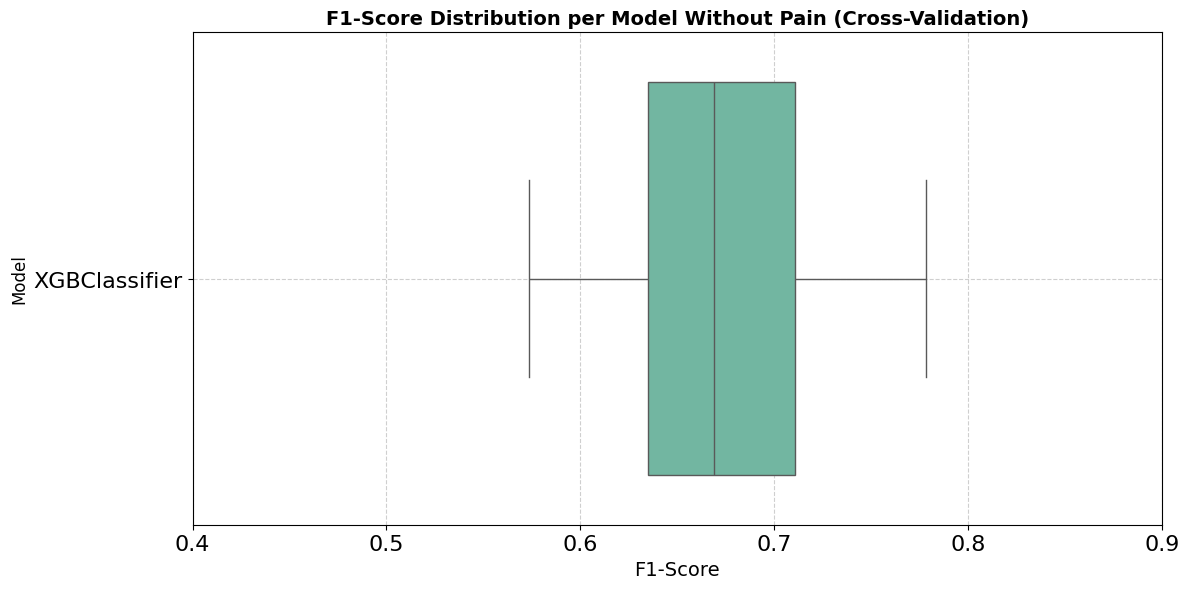

In [ ]:
models = {
    "XGBClassifier": xgb_model,
}


f1_scores = {}
for model_name, model in models.items():
    f1_scores[model_name] = cross_val_models_f1(df_train, model)

# Convert to DataFrame for ease of use with seaborn
f1_df = pd.DataFrame([
    {'Model': model_name, 'F1 Score': score}
    for model_name, scores in f1_scores.items()
    for score in scores
])

# Plot com seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(data=f1_df, y='Model', x='F1 Score', palette='Set2')
plt.title('F1-Score Distribution per Model Without Pain (Cross-Validation)', fontsize=14, fontweight='bold')
plt.xlabel('F1-Score', fontsize=14)
plt.ylabel('Model', fontsize=12)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlim(0.4,0.9)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()